In [50]:
using Evolutionary
using Flux
using Flux: onehot, onecold, logitcrossentropy, onehotbatch, crossentropy
using MLDatasets
using Random
using Statistics
using MLJBase
using Printf
using BSON: @load # for load weights
using BSON: @save # for load weights
using Plots
using DelimitedFiles
import Evolutionary.initial_population
using Zygote
import Evolutionary.NonDifferentiable
import Base: copy, copyto!
import JLD2


In [51]:
rawdata = readdlm("data/test2.csv",',',skipstart=1)';
one = 0
zero = 0
for i in rawdata[20,:]
if i == 1
    one = one + 1
else
    zero = zero + 1
end
end
difference = one - zero
function newrand()
    randCol = zeros(0)
    push!(randCol, rand(10.0:99.0))
    push!(randCol, rand(5.3:40.2))
    push!(randCol, rand(1.1:15.1))
    push!(randCol, rand(0.1:8.1))
    push!(randCol, rand(1.1:15.1))
    push!(randCol, rand(30.1:60.1))
    push!(randCol, rand(0.1:0.9))
    push!(randCol, rand(0.1:4.1))
    push!(randCol, rand(20.1:50.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(45.1:99.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(0.1:3.1))
    push!(randCol, rand(0.1:3.1))
    push!(randCol, rand(0.1:5.1))
    if rand(0:1) == 0
        push!(randCol, 0.0)
    else
        push!(randCol, 1.0)
    end
    return randCol
end
for i = 1:size(rawdata,2)
    if rawdata[20,i] == 0 && difference > 0
        rawdata = hcat(rawdata, rawdata[:,i])
        rawdata = hcat(rawdata, newrand())
        difference = difference - 1
    end
end
filldata = rawdata[ :, shuffle(1:end)];
x = filldata[1:19, :]
y = filldata[20, :];
x_train = x[:,1:floor(Int, size(x,2)*0.7)]
y_train = y[1:floor(Int, size(x,2)*0.7)]
x_test = x[:,floor(Int, size(x,2)*0.7)+1:end]
y_test = y[floor(Int, size(x,2)*0.7)+1:end];

In [52]:
train_data = [ (x, onehot(l, unique(y_train))) for (x, l) in zip(eachcol(x_train), y_train)]
test_data = [ (x, onehot(l, unique(y_test))) for (x, l) in zip(eachcol(x_test), y_test)];

In [55]:
train_data = [ (x, onehot(l, unique(y_train))) for (x, l) in zip(eachcol(x_train), y_train)]

1388-element Vector{Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, Flux.OneHotArray{UInt32, 2, 0, 1, UInt32}}}:
 ([42.0, 9.7, 3.4, 1.1, 3.1, 36.6, 0.5, 1.4, 35.1, 0.6, 0.9, 67.6, 0.1, 0.6, 0.7, 1.5, 0.4, 0.0, 0.5], [1, 0])
 ([76.0, 30.0, 13.4, 5.6, 11.6, 48.5, 0.0, 0.1, 0.0, 2.2, 3.2, 68.3, 3.0, 4.5, 7.5, 1.0, 0.7, 1.5, 2.0], [1, 0])
 ([49.0, 14.3, 12.1, 8.1, 9.1, 47.1, 0.1, 4.1, 29.1, 5.1, 7.1, 77.1, 1.1, 2.1, 1.1, 3.1, 2.1, 2.1, 1.1], [0, 1])
 ([49.0, 7.3, 2.6, 1.0, 2.6, 36.4, 0.0, 0.2, 22.2, 0.6, 1.0, 66.0, 0.2, 0.4, 0.6, 1.4, 0.3, 0.1, 0.9], [1, 0])
 ([71.0, 16.5, 4.9, 2.0, 4.4, 45.7, 0.3, 0.9, 31.1, 0.6, 1.0, 61.1, 0.3, 1.6, 1.9, 2.9, 0.9, 0.1, 1.4], [0, 1])
 ([78.0, 36.0, 16.1, 5.2, 12.1, 43.0, 0.6, 2.3, 28.2, 5.1, 6.0, 84.7, 0.8, 4.3, 5.1, 7.8, 2.2, 0.1, 2.4], [1, 0])
 ([48.0, 5.7, 1.1, 0.4, 1.8, 23.8, 0.0, 0.1, 16.7, 0.3, 0.4, 76.5, 0.2, 0.4, 0.6, 1.3, 0.3, 0.0, 0.5], [0, 1])
 ([62.0, 17.8, 7.0, 3.0, 7.0, 42.7, 0.3, 0.8, 30.8, 0.

In [54]:
JLD2.save_object("train_data.jld2", train_data)
JLD2.save_object("test_data.jld2", test_data)
JLD2.save_object("x_train.jld2", x_train)
JLD2.save_object("y_train.jld2", y_train)
JLD2.save_object("x_test.jld2", x_test)
JLD2.save_object("y_test.jld2", y_test)

In [18]:
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)
loss(model) = (x,y)->logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))
myaccuracy(x, y) = mean(onecold(model(x)) .== onecold(y))


myaccuracy (generic function with 1 method)

In [28]:
epochs = 1000 # the number of epochs
# change population_size will increase training time, but may increase the accuracy
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))#define the model 


Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [20]:
optim = ADAM()


ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [ ]:
accuracy(test_data, model)

In [ ]:
accuracy(train_data, model)

In [29]:
for i in 1:1

    for j in 1:epochs
        Flux.train!(loss(model), Flux.params(model), train_data, ADAM(1e-4))
        #@printf("Loss in epoch: %d in test is %f\n", j, loss(x_test, y_test))
        save_resultTest[j] = save_resultTest[j] + accuracy(test_data, model)
        save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, model)
    end
end


In [30]:
accuracy(test_data, model)

0.6677852348993288

In [31]:
accuracy(train_data, model)

0.8162824207492796

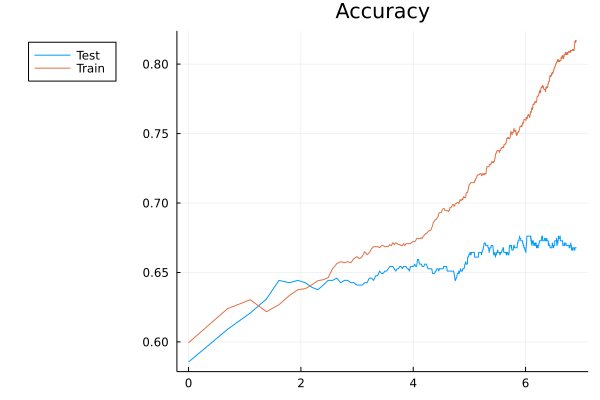

In [33]:
save_resultTest = save_resultTest ./ 1;
save_resultTrain = save_resultTrain ./ 1;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [32]:
# savepath = string("newmodel/model",8166,".bson")
# @save savepath model

In [47]:
fitness(m) = loss(train_data, m)

fitness (generic function with 1 method)

In [41]:
NonDifferentiable(f, x::Chain) = NonDifferentiable{Real,typeof(x)}(f, f(x), deepcopy(x),[0,])
copy(ch::Chain) = deepcopy(ch)
# copy weight and bias between two models
function copyto!(layer1::Dense{T}, layer2::Dense{T}) where {T}
    copyto!(layer1.W, layer2.W)
    copyto!(layer1.b, layer2.b)
    return l1
end
function copyto!(ch1::Chain, ch2::Chain)
    for i in 1:length(ch1.layers)
        copyto!(ch1.layers[i],ch2.layers[i])
    end
    return ch1
end

copyto! (generic function with 140 methods)

In [42]:
opts = Evolutionary.Options(iterations=1,successive_f_tol= 2)
algo = ES(
    μ=50, 
    λ=3*50, 
    selection=:plus)


ES(NoStrategy(), first, first, Evolutionary.var"#42#45"(), identity, 50, 50, 150, :plus)

In [48]:
epochs = 60 # the number of epochs
# change population_size will increase training time, but may increase the accuracy
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))#define the model 

Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [38]:
accuracy(test_data, model)

0.5167785234899329

In [39]:
accuracy(train_data, model)

0.4935158501440922

In [44]:
function initial_population(method::M, individual::Chain) where {M<:Evolutionary.AbstractOptimizer}
    θ, re = Flux.destructure(individual);
    [re(randn(length(θ))) for i in 1:Evolutionary.population_size(method)]
    end

initial_population (generic function with 6 methods)

In [ ]:
function gaussian_mlp(σ::Real = 1.0)
    vop = gaussian(σ)
    function mutation(recombinant::T) where {T <: Chain}
        θ, re = Flux.destructure(recombinant)
        return re(convert(Vector{Float32}, vop(θ)))
    end
    return mutation
end

In [49]:
res = Evolutionary.optimize(fitness, model, algo, opts)
evomodel = Evolutionary.minimizer(res)

for j in 1:epochs
    res = Evolutionary.optimize(fitness, model, algo, opts)
    model= Evolutionary.minimizer(res)
    # if j%(epochs/5) == 0
    # @printf("Loss in expirment %d epoch: %d in test data is %f\n",i, j, loss(test_data,model))
    # end
    save_resultTest[j] = save_resultTest[j] + accuracy(test_data, model)
    save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, model)
end


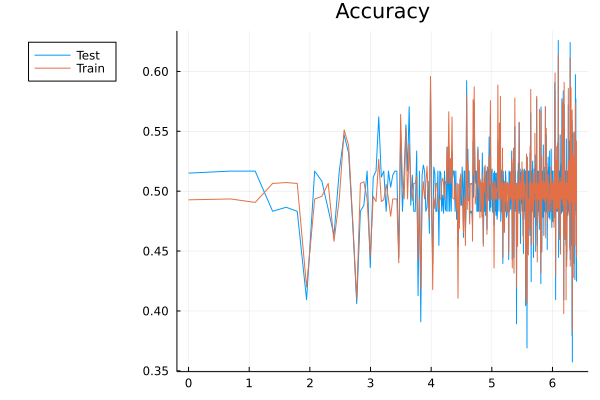

In [46]:
save_resultTest = save_resultTest ./ 1;
save_resultTrain = save_resultTrain ./ 1;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [ ]:
simplified_x_train_result = []
for i  = 1:size(x_train,2)
    if softmax(model(x_train[:,i]))[1]>0.5
        push!(simplified_x_train_result, 0)
    else
        push!(simplified_x_train_result, 1)
    end
end
simplified_y_train = []
for i  = 1:size(x_train,2)
    if y_train[i] == 0
        push!(simplified_y_train, 0)
    else
        push!(simplified_y_train, 1)
    end
end

# ConfusionMatrix for the training data
print("ConfusionMatrix for the training data\n")
ConfusionMatrix()(simplified_x_train_result, simplified_y_train)

In [ ]:
simplified_x_test_result = []
for i  = 1:size(x_test,2) 
    if softmax(model(x_test[:,i]))[1]>0.5
        push!(simplified_x_test_result, 0)
    else
        push!(simplified_x_test_result, 1)
    end
end
simplified_y_test = []
for i  = 1:size(x_test,2) 
    if y_test[i] == 0
        push!(simplified_y_test, 0)
    else
        push!(simplified_y_test, 1)
    end
end

# ConfusionMatrix for the test data
print("ConfusionMatrix for the test data\n")
ConfusionMatrix()(simplified_x_test_result, simplified_y_test)